In [1]:
import sys
sys.path.append('../../src')

from common import common, transform, json
from tracker import main as tr
from individual_activity import main as ia
from group_activity import main as ga
from display.display import display
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Indivisual Activity をロード

In [2]:
room_num = '09'
date = '20210304'
name = 'gaze1-1'

In [3]:
individual_activity_json = os.path.join(
    common.data_dir, '{0}/{1}/{2}/json/individual_activity.json'.format(room_num, date, name))
field_path = os.path.join(
    common.data_dir, 'field.png')

In [4]:
# homography
field_raw = cv2.imread(field_path)
p_video = common.homo[room_num][0]
p_field = common.homo[room_num][1]
homo = transform.Homography(p_video, p_field, field_raw.shape)

In [5]:
individual_activity_data = json.load(individual_activity_json)

In [6]:
from common.json import IA_FORMAT
from individual_activity.individual_activity import IndividualActivity

def make_individuals(datas, homo):
    individuals = {}
    for data in datas:
        label = data[IA_FORMAT[0]]
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        for key in IA_FORMAT[3:]:
            ia.indicator_dict[key][frame_num] = data[key]
            
    return list(individuals.values())

In [7]:
individuals = make_individuals(individual_activity_data, homo)

#　対象物を予測する
1. 各個人のポジションと対象物の線と顔の向きのコサイン類似度を求める
2. コサイン類似度が0に近い対象物を視線の先の対象物とする

In [8]:
from common.functions import normalize_vector, cos_similarity

In [9]:
manual_results = {
    'gaze1-1': {'frame': 350, 'order': [0, 2, 1]},
    'gaze1-2': {'frame': 310, 'order': [0, 1, 2]},
    'gaze1-3': {'frame': 275, 'order': [0, 1, 2]},
    'gaze2-1': {'frame': 276, 'order': [0, 1, 2]},
    'gaze2-2': {'frame': 286, 'order': [0, 1, 2]},
    'gaze2-3': {'frame': 283, 'order': [0, 1, 2]},
    'gaze3-1': {'frame': 311, 'order': [0, 1, 2]},
    'gaze3-2': {'frame': 297, 'order': [0, 1, 2]},
    'gaze3-3': {'frame': 305, 'order': [0, 1, 2]},
}

object_points = {
    1: (679, 772),  # monitor
    2: (54, 772),   # PC
    3: (368, 420),  # operating table
}

th_cos = np.cos(np.pi / 18)

In [10]:
def predict_object(individuals):
    max_frame_num = max([max(individual.tracking_points.keys()) for individual in individuals])
    
    predict = []
    for frame_num in range(max_frame_num):
        objects = []
        for i, individual in enumerate(individuals):
            position = individual.get_data('position', frame_num)
            face = individual.get_data('face_vector', frame_num)

            if position is None or face is None:
                continue

#             max_cos = -1
#             max_label = 0
            th_cos = np.cos(np.pi / 6)
            individual_objects = []
            for label, obj in object_points.items():
                pos2obj = np.array(obj) - position
                pos2obj = normalize_vector(pos2obj.astype(float))
                cos = cos_similarity(face, pos2obj)

#                 if max_cos < cos:
#                     max_cos = cos
#                     max_label = label
                if cos > th_cos:
                    individual_objects.append(label)
                
#             objects.append(max_label)
            objects.append(individual_objects)
            
        predict.append(objects)

    return predict

In [11]:
pred_objs = predict_object(individuals)

In [12]:
pred_objs[-1]

[[1], [1], [1]]

# 検証・評価

In [13]:
csv_path = os.path.join(common.data_dir, '{0}/{1}/{2}/csv/data.csv'.format(room_num, date, name))
csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

test_y = []
for row in csv_data:
    test_y.append(row[4])

In [14]:
pred = []
for objs, y in zip(pred_objs, test_y):
    count = 0
    for individual_objs in objs:
        if y in individual_objs:
            # 各個人の視野内にある対象物にyが含まれる
            count += 1
    
    # 視野にyが含まれる人数 / 全人数
    likelihood = count / len(objs)
    pred.append(likelihood)
    
test_y = np.array(test_y)
true_y = test_y == test_y[-1]

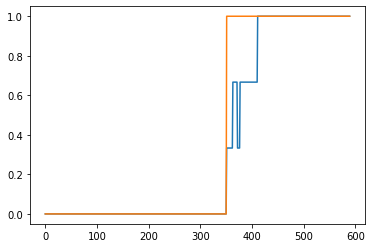

In [15]:
plt.plot(pred)
plt.plot(true_y)

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

accuracy: 0.971
precision: 1.000
recall: 0.929
f1_score: 0.963


<AxesSubplot:>

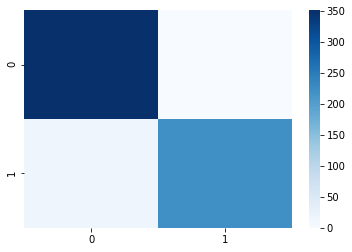

In [17]:
pred = (np.array(pred) > 0.5) * 1
print('accuracy: {:.3f}'.format(accuracy_score(true_y, pred)))
print('precision: {:.3f}'.format(precision_score(true_y, pred)))
print('recall: {:.3f}'.format(recall_score(true_y, pred)))
print('f1_score: {:.3f}'.format(f1_score(true_y, pred)))

cm = confusion_matrix(true_y, pred)
sns.heatmap(cm, cmap='Blues')

In [18]:
room_num = '09'
date = '20210304'
names = ['gaze1-1', 'gaze1-2', 'gaze1-3', 'gaze2-1', 'gaze2-2', 'gaze2-3', 'gaze3-1', 'gaze3-2', 'gaze3-3']

object_points = {
    1: (679, 772),  # monitor
    2: (54, 772),   # PC
    3: (368, 420),  # operating table
}

scores = []
for name in names:
    individual_activity_json = os.path.join(
        common.data_dir, '{0}/{1}/{2}/json/individual_activity.json'.format(room_num, date, name))
    field_path = os.path.join(
        common.data_dir, 'field.png')
    
    # homography
    field_raw = cv2.imread(field_path)
    p_video = common.homo[room_num][0]
    p_field = common.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    
    # load data
    individual_activity_data = json.load(individual_activity_json)
    individuals = make_individuals(individual_activity_data, homo)
    
    # predict gazed object
    pred_objs = predict_object(individuals)
    
    # load csv
    csv_path = os.path.join(common.data_dir, '{0}/{1}/{2}/csv/data.csv'.format(room_num, date, name))
    csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)
    test_y = []
    for row in csv_data:
        test_y.append(row[4])
        
    # predict attention
    pred = []
    for objs, y in zip(pred_objs, test_y):
        count = 0
        for individual_objs in objs:
            if y in individual_objs:
                # 各個人の視野内にある対象物にyが含まれる
                count += 1

        # 視野にyが含まれる人数 / 全人数
        likelihood = count / len(objs)
        pred.append(likelihood)
    pred = (np.array(pred) > 0.5) * 1

    test_y = np.array(test_y)
    true_y = test_y == test_y[-1]
    
    # score
    score = f1_score(true_y, pred)
    scores.append(score)
    print('{}: {}'.format(name, score))
    
mean_score = sum(scores) / len(scores)
print('mean of the f1 scores: {}'.format(mean_score))

gaze1-1: 0.963123644251627
gaze1-2: 0.3812154696132597
gaze1-3: 0.07096774193548389
gaze2-1: 1.0
gaze2-2: 0.3812154696132597
gaze2-3: 0.7787234042553192
gaze3-1: 0.9716312056737589
gaze3-2: 0.9540636042402826
gaze3-3: 0.4132231404958678
mean of the f1 scores: 0.6571292977865398
